In [19]:
%load_ext autoreload
%autoreload 2
%run ./initializer

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Path (/Users/madalenabarcelo/Desktop/BA/DMT/assignment_2/DataMiningTechniquesA2) already exists in sys.path


In [20]:
import pandas as pd
from lgbm_ranker import LGBMRankerModel, LGBMRanker
from feature_tester import FeatureTester
import numpy as np

In [21]:
train_df = pd.read_parquet("data/training_set_processed.parquet")
test_df = pd.read_parquet("data/test_set_processed.parquet")

In [22]:
params_fixed = {
    "objective": "lambdarank",
    "metric": "ndcg",
    "ndcg_eval_at": [5],
    "boosting_type": "gbdt",
    "n_estimators": 10000,
}
params_initial = {
    "learning_rate": 0.05,
}
params_small_hpo = {
    "learning_rate": 0.03427673821049949,
    "num_leaves": 79,
    "min_child_samples": 50,
    "reg_alpha": 0.0001416721648867782,
    "reg_lambda": 0.12245976197134716,
}
params_hpo = {
    "n_estimators": 1500,
    'learning_rate': 0.03928543917526321, 
    'num_leaves': 151, 
    'min_child_samples': 100, 
    'min_child_weight': 9.84223213747703, 
    'colsample_bytree': 0.5340379911098179, 
    'subsample': 0.9940711682871947, 
    'reg_alpha': 0.009867816340998009, 
    'reg_lambda': 8.490860770966702
    }

params = {**params_fixed, **params_hpo}
lgbm_class_model = LGBMRankerModel(train_df, params)

In [25]:
X_train, y_train, X_val, y_val, groups_size_train, groups_size_val = lgbm_class_model.format_data(train_df)

In [26]:
fitted_model = lgbm_class_model.fit(X_train, y_train, X_val, y_val, groups_size_train, groups_size_val)

/Users/madalenabarcelo/Desktop/BA/DMT/assignment_2/DataMiningTechniquesA2/.venv/lib/python3.10/site-packages/lightgbm/sklearn.py:861: UserWarning: Found 'ndcg_eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")


[LightGBM] [Warning] Met categorical feature which contains sparse values. Consider renumbering to consecutive integers started from zero
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.501918 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8851
[LightGBM] [Info] Number of data points in the train set: 3966677, number of used features: 122
Training until validation scores don't improve for 500 rounds
[250]	valid_0's ndcg@5: 0.406132
[500]	valid_0's ndcg@5: 0.409723
[750]	valid_0's ndcg@5: 0.410501
[1000]	valid_0's ndcg@5: 0.41061
Early stopping, best iteration is:
[673]	valid_0's ndcg@5: 0.410987


In [ ]:
# Bias analysis considering only top positions
from sklearn.metrics import ndcg_score

# Step 3: Add back srch_id and country columns to validation data
val_df = train_df.loc[X_val.index].copy()
val_df["y_true"] = y_val
val_df["y_pred"] = fitted_model.predict(X_val)

# Step 4: Create domestic/international flags
val_df["is_domestic"] = val_df["visitor_location_country_id"] == val_df["prop_country_id"]

def compute_group_ndcg(df, group_col="srch_id", score_col="y_pred", true_col="y_true", k=5):
    group_scores = []
    for _, group in df.groupby(group_col):
        # Skip if only 1 hotel or no relevant items in group
        if len(group) < 2 or group[true_col].sum() == 0:
            continue
        relevance = group[true_col].values.reshape(1, -1)
        scores = group[score_col].values.reshape(1, -1)
        try:
            score = ndcg_score(relevance, scores, k=k)
            group_scores.append(score)
        except ValueError:
            continue  # If sklearn still throws, skip the group
    if not group_scores:
        return np.nan
    return np.mean(group_scores)

# Binary evaluation: confusion matrix + metrics
def compute_classification_metrics(df, group_name="Unknown"):
    y_true = df["y_true"].astype(int).values
    y_pred = df["y_pred"].astype(int).values

    if len(np.unique(y_true)) < 2 or len(np.unique(y_pred)) < 2:
        print(f"Not enough variation in labels for {group_name}.")
        return

    tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels=[0, 1]).ravel()
    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
    fnr = fn / (fn + tp) if (fn + tp) > 0 else 0
    error_rate = (fp + fn) / len(df)

    print(f"{group_name} Travelers:")
    print(f"  False Positives: {fp}")
    print(f"  False Negatives: {fn}")
    print(f"  FPR: {fpr:.4f}, FNR: {fnr:.4f}, Error Rate: {error_rate:.4f}")
    print("")

# Split groups
domestic_df = val_df[val_df["is_domestic"]]
international_df = val_df[~val_df["is_domestic"]]

# NDCG scores
ndcg_domestic = compute_group_ndcg(domestic_df)
ndcg_international = compute_group_ndcg(international_df)

print(f"NDCG@5 - Domestic travelers: {ndcg_domestic:.4f}")
print(f"NDCG@5 - International travelers: {ndcg_international:.4f}")
print("")

# Compute errors and bias-related metrics
compute_classification_metrics(domestic_df, "Domestic")
compute_classification_metrics(international_df, "International")

/Users/madalenabarcelo/Desktop/BA/DMT/assignment_2/DataMiningTechniquesA2/.venv/lib/python3.10/site-packages/lightgbm/sklearn.py:861: UserWarning: Found 'ndcg_eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")


NDCG@5 - Domestic travelers: 0.4194
NDCG@5 - International travelers: 0.3986

Domestic Travelers:
  False Positives: 21268
  False Negatives: 6381
  FPR: 0.0635, FNR: 0.8693, Error Rate: 0.0438

International Travelers:
  False Positives: 9410
  False Negatives: 4991
  FPR: 0.0427, FNR: 0.8905, Error Rate: 0.0400



In [ ]:
# BIas analysis for hotels with different star ratings - only for top 5 properties

# Optional: round starrating to handle float issues, if needed
val_df["prop_starrating"] = val_df["prop_starrating"].round()

# Step 2: Define thresholds for classifying predictions as positive
threshold = 0.5  # you can adjust this depending on model output scale

def compute_error_rates(df):
    """
    Compute FPR, FNR, and error rate for a group.
    """
    y_true = df["y_true"]
    y_pred = (df["y_pred"] >= threshold).astype(int)

    false_positives = ((y_pred == 1) & (y_true == 0)).sum()
    false_negatives = ((y_pred == 0) & (y_true == 1)).sum()
    true_negatives = ((y_pred == 0) & (y_true == 0)).sum()
    true_positives = ((y_pred == 1) & (y_true == 1)).sum()

    total = len(df)
    error_rate = (false_positives + false_negatives) / total if total > 0 else float("nan")
    fpr = false_positives / (false_positives + true_negatives) if (false_positives + true_negatives) > 0 else float("nan")
    fnr = false_negatives / (false_negatives + true_positives) if (false_negatives + true_positives) > 0 else float("nan")

    return {
        "False Positives": false_positives,
        "False Negatives": false_negatives,
        "FPR": fpr,
        "FNR": fnr,
        "Error Rate": error_rate
    }

# Loop through star ratings from 0 to 5
for star in range(0, 6):
    group_df = val_df[val_df["prop_starrating"] == star]
    if len(group_df) < 20:
        print(f"\n{star}-Star Hotels: Too few samples, skipping.")
        continue

    metrics = compute_error_rates(group_df)
    print(f"\n{star}-Star Hotels (n={len(group_df)}):")
    for key, val in metrics.items():
        print(f"  {key}: {val:.4f}" if isinstance(val, float) else f"  {key}: {val}")


0-Star Hotels (n=33682):
  False Positives: 313
  False Negatives: 424
  FPR: 0.0096
  FNR: 0.9636
  Error Rate: 0.0219

1-Star Hotels (n=3370):
  False Positives: 18
  False Negatives: 55
  FPR: 0.0055
  FNR: 1.0000
  Error Rate: 0.0217

2-Star Hotels (n=179626):
  False Positives: 4440
  False Negatives: 2106
  FPR: 0.0256
  FNR: 0.9269
  Error Rate: 0.0364

3-Star Hotels (n=389322):
  False Positives: 28449
  False Negatives: 5022
  FPR: 0.0764
  FNR: 0.8153
  Error Rate: 0.0860

4-Star Hotels (n=305473):
  False Positives: 47195
  False Negatives: 4249
  FPR: 0.1633
  FNR: 0.6744
  Error Rate: 0.1684

5-Star Hotels (n=80197):
  False Positives: 8995
  False Negatives: 1160
  FPR: 0.1175
  FNR: 0.7309
  Error Rate: 0.1266


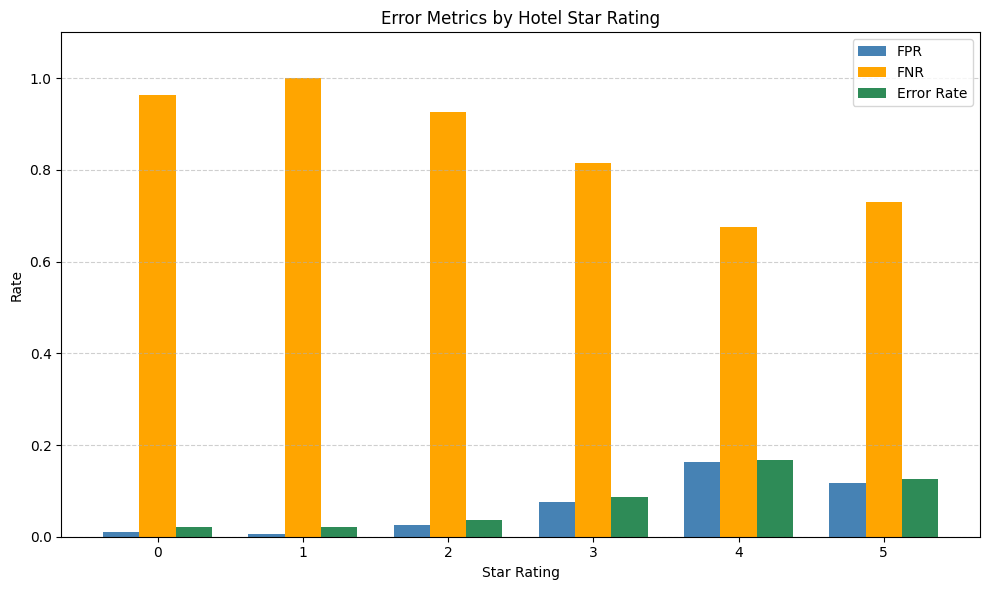

In [35]:
import matplotlib.pyplot as plt
import numpy as np

# Star ratings
star_ratings = [0, 1, 2, 3, 4, 5]

# Metrics
fpr = [0.0096, 0.0055, 0.0256, 0.0764, 0.1633, 0.1175]
fnr = [0.9636, 1.0000, 0.9269, 0.8153, 0.6744, 0.7309]
error_rate = [0.0219, 0.0217, 0.0364, 0.0860, 0.1684, 0.1266]

# Bar width and position
bar_width = 0.25
x = np.arange(len(star_ratings))

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(x - bar_width, fpr, width=bar_width, label='FPR', color='steelblue')
plt.bar(x, fnr, width=bar_width, label='FNR', color='orange')
plt.bar(x + bar_width, error_rate, width=bar_width, label='Error Rate', color='seagreen')

# Labels and layout
plt.xlabel('Star Rating')
plt.ylabel('Rate')
plt.title('Error Metrics by Hotel Star Rating')
plt.xticks(x, star_ratings)
plt.ylim(0, 1.1)
plt.legend()
plt.grid(True, axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


In [ ]:
# Bias analysis using hotels in all positions (not just top 5)

import pandas as pd
from collections import defaultdict

def get_group_classification_metrics(group, k=5):
    group_sorted_pred = group.sort_values("y_pred", ascending=False).head(k)
    group_sorted_true = group[group["y_true"] >= 1].sort_values("y_true", ascending=False).head(k)

    pred_top_ids = set(group_sorted_pred.index)
    true_top_ids = set(group_sorted_true.index)

    tp = len(pred_top_ids & true_top_ids)
    fp = len(pred_top_ids - true_top_ids)
    fn = len(true_top_ids - pred_top_ids)
    tn = len(group) - (tp + fp + fn)

    return tp, fp, fn, tn

def compute_metrics_by_group(df, group_col, k=5):
    results = {}

    for group_value, subset in df.groupby(group_col):
        tp_total = fp_total = fn_total = tn_total = 0
        for _, group in subset.groupby("srch_id"):
            tp, fp, fn, tn = get_group_classification_metrics(group, k=k)
            tp_total += tp
            fp_total += fp
            fn_total += fn
            tn_total += tn

        total = tp_total + fp_total + fn_total + tn_total
        fpr = fp_total / (fp_total + tn_total) if (fp_total + tn_total) > 0 else 0
        fnr = fn_total / (fn_total + tp_total) if (fn_total + tp_total) > 0 else 0
        error_rate = (fp_total + fn_total) / total if total > 0 else 0

        results[group_value] = {
            "False Positives": fp_total,
            "False Negatives": fn_total,
            "True Positives": tp_total,
            "True Negatives": tn_total,
            "FPR": round(fpr, 4),
            "FNR": round(fnr, 4),
            "Error Rate": round(error_rate, 4),
            "n": len(subset)
        }

    return pd.DataFrame(results).T.sort_index()

# --- Apply to domestic vs. international ---
val_df["is_domestic"] = val_df["visitor_location_country_id"] == val_df["prop_country_id"]
domestic_vs_intl_results = compute_metrics_by_group(val_df, "is_domestic", k=5)
print("Domestic vs. International")
print(domestic_vs_intl_results)

# --- Apply to star ratings ---
val_df["prop_starrating"] = val_df["prop_starrating"].fillna(0).astype(int)
starrating_results = compute_metrics_by_group(val_df, "prop_starrating", k=5)
print("\nStar Rating Results")
print(starrating_results)


Domestic vs. International
       False Positives  False Negatives  True Positives  True Negatives  \
False          64724.0           7320.0          9186.0        278854.0   
True          110051.0          11446.0         16103.0        493986.0   

          FPR     FNR  Error Rate         n  
False  0.1884  0.4435      0.2001  360084.0  
True   0.1822  0.4155      0.1924  631586.0  

Star Rating Results
   False Positives  False Negatives  True Positives  True Negatives     FPR  \
0          28471.0             59.0           942.0          4210.0  0.8712   
1           3164.0              4.0            99.0           103.0  0.9685   
2         101073.0            995.0          5222.0         72336.0  0.5829   
3         153903.0           3916.0         12954.0        218549.0  0.4132   
4         129322.0           3559.0         12887.0        159705.0  0.4474   
5          49239.0            636.0          2994.0         27328.0  0.6431   

      FNR  Error Rate         n  


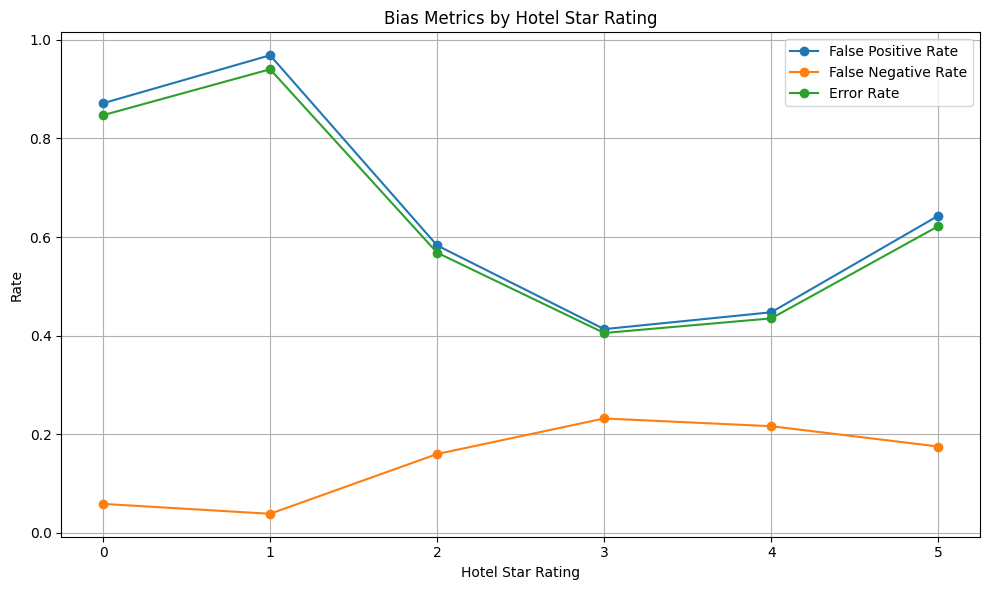

In [37]:
import matplotlib.pyplot as plt
import pandas as pd

# Your results data
star_results = pd.DataFrame({
    "Star Rating": [0, 1, 2, 3, 4, 5],
    "FPR": [0.8712, 0.9685, 0.5829, 0.4132, 0.4474, 0.6431],
    "FNR": [0.0589, 0.0388, 0.1600, 0.2321, 0.2164, 0.1752],
    "Error Rate": [0.8470, 0.9401, 0.5682, 0.4054, 0.4350, 0.6219]
})

# Plot
plt.figure(figsize=(10, 6))
plt.plot(star_results["Star Rating"], star_results["FPR"], label="False Positive Rate", marker="o")
plt.plot(star_results["Star Rating"], star_results["FNR"], label="False Negative Rate", marker="o")
plt.plot(star_results["Star Rating"], star_results["Error Rate"], label="Error Rate", marker="o")

plt.xticks(star_results["Star Rating"])
plt.xlabel("Hotel Star Rating")
plt.ylabel("Rate")
plt.title("Bias Metrics by Hotel Star Rating")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:

# Post processing

from sklearn.isotonic import IsotonicRegression
from sklearn.metrics import precision_recall_fscore_support, accuracy_score


# 1. Bin relevance into binary for calibration
val_df["relevance_binary"] = (val_df["y_true"] >= 1).astype(int)

# 2. Fit isotonic regression calibrators per star rating
calibrators = {}
for star in sorted(val_df["prop_starrating"].unique()):
    group = val_df[val_df["prop_starrating"] == star]
    if group["relevance_binary"].nunique() < 2:
        continue  # skip groups without positive and negative samples
    iso_reg = IsotonicRegression(out_of_bounds="clip")
    iso_reg.fit(group["y_pred"], group["relevance_binary"])
    calibrators[star] = iso_reg

# 3. Apply calibration function
def apply_calibration(row, calibrators):
    star = row["prop_starrating"]
    if star in calibrators:
        return calibrators[star].predict([row["y_pred"]])[0]
    else:
        return row["y_pred"]  # fallback if no calibrator

val_df["y_pred_calibrated"] = val_df.apply(lambda row: apply_calibration(row, calibrators), axis=1)


# Optional Step 4: Tune threshold per star rating group for best F1
def tune_thresholds_per_star(df, star_col="prop_starrating", y_true_col="relevance_binary", y_score_col="y_pred_calibrated", num_thresh=100):
    thresholds = np.linspace(0, 1, num_thresh)
    best_thresh = {}
    for star in sorted(df[star_col].unique()):
        group = df[df[star_col] == star]
        y_true = group[y_true_col].values
        y_scores = group[y_score_col].values

        best_f1 = -1
        best_t = 0.5
        for t in thresholds:
            y_pred = (y_scores >= t).astype(int)
            _, _, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='binary', zero_division=0)
            if f1 > best_f1:
                best_f1 = f1
                best_t = t
        best_thresh[star] = best_t
    return best_thresh

best_thresholds = tune_thresholds_per_star(val_df)
print("Best thresholds per star rating:", best_thresholds)


# Step 5: Apply binarization with group-specific thresholds
def binarize_with_thresholds(row, thresh_dict):
    star = row["prop_starrating"]
    thresh = thresh_dict.get(star, 0.5)  # default 0.5 if no threshold found
    return int(row["y_pred_calibrated"] >= thresh)

val_df["y_pred_calibrated_bin"] = val_df.apply(lambda row: binarize_with_thresholds(row, best_thresholds), axis=1)






Best thresholds per star rating: {np.int64(0): np.float64(0.09090909090909091), np.int64(1): np.float64(0.07070707070707072), np.int64(2): np.float64(0.07070707070707072), np.int64(3): np.float64(0.09090909090909091), np.int64(4): np.float64(0.10101010101010102), np.int64(5): np.float64(0.09090909090909091)}
   prop_starrating  precision    recall  f1_score  accuracy  support
0                0   0.144799  0.244755  0.181953  0.934594    33682
1                1   0.114754  0.135922  0.124444  0.941543     3370
2                2   0.105677  0.267631  0.151523  0.896129   179626
3                3   0.131777  0.262572  0.175484  0.892880   389322
4                4   0.150414  0.295537  0.199362  0.871845   305473
5                5   0.138305  0.238462  0.175071  0.898001    80197


In [46]:
def calculate_metrics(df):
    metrics = []
    for star in sorted(df['prop_starrating'].unique()):
        group = df[df['prop_starrating'] == star]
        TP = ((group['y_pred_calibrated_bin'] == 1) & (group['relevance_binary'] == 1)).sum()
        TN = ((group['y_pred_calibrated_bin'] == 0) & (group['relevance_binary'] == 0)).sum()
        FP = ((group['y_pred_calibrated_bin'] == 1) & (group['relevance_binary'] == 0)).sum()
        FN = ((group['y_pred_calibrated_bin'] == 0) & (group['relevance_binary'] == 1)).sum()

        FPR = FP / (FP + TN) if (FP + TN) > 0 else 0
        FNR = FN / (FN + TP) if (FN + TP) > 0 else 0
        Error_Rate = (FP + FN) / len(group) if len(group) > 0 else 0
        
        metrics.append({
            'prop_starrating': star,
            'FPR': FPR,
            'FNR': FNR,
            'Error Rate': Error_Rate
        })
    return pd.DataFrame(metrics)

post_processed_metrics = calculate_metrics(val_df)

In [47]:
print(post_processed_metrics)

   prop_starrating       FPR       FNR  Error Rate
0                0  0.044276  0.755245    0.065406
1                1  0.033058  0.864078    0.058457
2                2  0.081309  0.732369    0.103871
3                3  0.078514  0.737428    0.107120
4                4  0.095266  0.704463    0.128155
5                5  0.070640  0.761538    0.101999


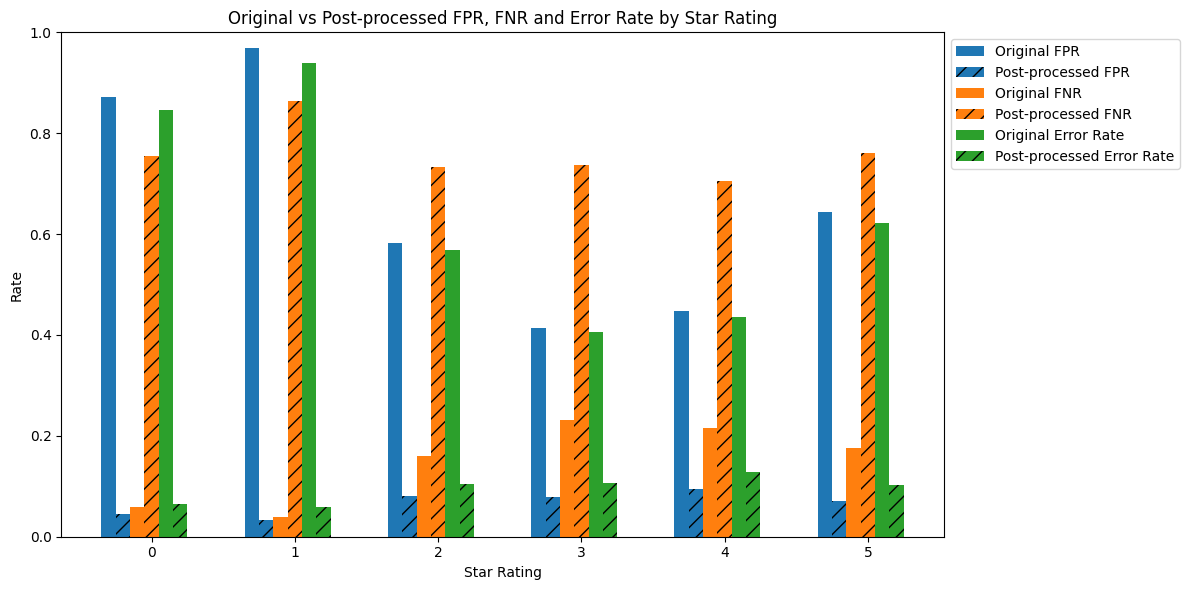

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Original metrics (from your earlier data)
original_metrics = pd.DataFrame({
    'prop_starrating': [0, 1, 2, 3, 4, 5],
    'FPR': [0.8712, 0.9685, 0.5829, 0.4132, 0.4474, 0.6431],
    'FNR': [0.0589, 0.0388, 0.1600, 0.2321, 0.2164, 0.1752],
    'Error Rate': [0.8470, 0.9401, 0.5682, 0.4054, 0.4350, 0.6219]
})

# Post-processed metrics (the ones you gave me)
post_processed_metrics = pd.DataFrame({
    'prop_starrating': [0, 1, 2, 3, 4, 5],
    'FPR': [0.044276, 0.033058, 0.081309, 0.078514, 0.095266, 0.070640],
    'FNR': [0.755245, 0.864078, 0.732369, 0.737428, 0.704463, 0.761538],
    'Error Rate': [0.065406, 0.058457, 0.103871, 0.107120, 0.128155, 0.101999]
})

metrics = ['FPR', 'FNR', 'Error Rate']
x = original_metrics['prop_starrating']
x_indices = np.arange(len(x))
bar_width = 0.3

fig, ax = plt.subplots(figsize=(12,6))
colors = ['tab:blue', 'tab:orange', 'tab:green']

for i, metric in enumerate(metrics):
    pos_orig = x_indices - bar_width + i * (bar_width * 2 / len(metrics))
    pos_post = pos_orig + bar_width / len(metrics)
    
    ax.bar(pos_orig, original_metrics[metric], width=bar_width / len(metrics),
           color=colors[i], label=f'Original {metric}')
    ax.bar(pos_post, post_processed_metrics[metric], width=bar_width / len(metrics),
           color=colors[i], hatch='//', label=f'Post-processed {metric}')

ax.set_xticks(x_indices)
ax.set_xticklabels(x)
ax.set_xlabel('Star Rating')
ax.set_ylabel('Rate')
ax.set_title('Original vs Post-processed FPR, FNR and Error Rate by Star Rating')
ax.legend(loc='upper left', bbox_
to_anchor=(1,1))
ax.set_ylim(0, 1)
plt.tight_layout()
plt.show()
